In [348]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from skimage import img_as_ubyte



# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj3/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /content/drive/My Drive/cs445_projects/proj3/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj3/samples: No such file or directory


## Input Shadow Image and Mask

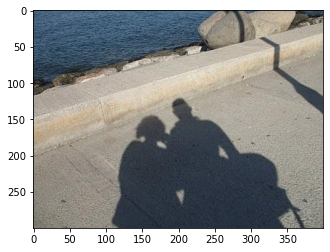

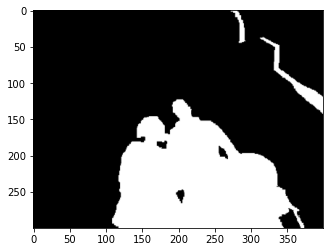

In [349]:
#309834_600
#87563
#338398251_04f8821e2e_z



#0_90968_12d98a11_XL
#DSCF4142


shadow_img = cv2.cvtColor(cv2.imread('SBU-shadow/SBU-Test/ShadowImages/DSCF4142.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(shadow_img)
plt.show()


mask_img = cv2.cvtColor(cv2.imread('SBU-shadow/SBU-Test/ShadowMasks/DSCF4142.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(mask_img)
plt.show()


#x = 375
#y = 300
#plt.imshow(shadow_img[x:(x+12), y:(y+12),:])
#plt.show()

#plt.imshow(mask_img[x:(x+12), y:(y+12),:])
#plt.show()

In [364]:
def computeAverage(arr):
    arr[arr == 0] = np.nan
    arr_mean = np.nanmean(arr, axis=1)
    arr_mean = np.nanmean(arr_mean, axis=0)

    return arr_mean

def getIntensityRatio(imgPatch, maskPatch):
    
    s = imgPatch
    m = maskPatch
    
    shd = s*m
    non_shd = s*np.logical_not(m)

    shd_mean = computeAverage(shd)
    non_shd_mean = computeAverage(non_shd)

    r = (non_shd_mean - shd_mean) / (shd_mean*1 - non_shd_mean*0)
    
    return r


def fixPatchShadow(imgPatch, maskPatch, ratio):
    
    mapper = (ratio + 1)/(ratio*np.logical_not(maskPatch) + 1)
    
    fixed = imgPatch*mapper
    
    fg = fixed*maskPatch


    
    
    bg = fixed*np.logical_not(maskPatch)

    
    final = (fg)+bg
    
    return final



def getMaskRatio(m):
    
    totalCount = m.shape[0]*m.shape[1]
    
    
    mOnes = np.count_nonzero(m[:,:,0]) 
    mZeros = totalCount - mOnes
    
    
    patchRatio = mOnes  / (mOnes + mZeros)
    
    return patchRatio




def getPatch(mask_img, shadow_img, x, y, patch_size, width, height):

    xE = x + patch_size
    yE = y + patch_size
    
    if(xE >= height):
        xE = xE - (xE - height + 1)

    if(yE >= width):
        yE = yE - (yE - width + 1)
        
    
    m = mask_img[x:xE, y:yE,:].copy()
    
    s = shadow_img[x:xE, y:yE,:].copy()    

    
    maskRatio = getMaskRatio(m)
    
    
    if(maskRatio > 0.4 and maskRatio < 0.6):
        return s, m, True
    else:
        return None, None, False
        
        
    #else:
        #fixPatchRatio(mask_img, x, y, xE, yE)
        #pass
    
    
def updateBins(bins, binIndx, r):
    
    for i in range(3):
        currentR = round(r[i], 1)
        
        if(int(currentR*10) < len(binIndx)):
            bins[int(currentR*10), i]  = bins[int(currentR*10),i] + 1
        
    return bins


def getFinalRatio(bins, binIndx):
    
    r = np.zeros(3).astype('float64')
    

    
    indx = np.where(bins == np.max(bins, axis=0))
    
    prevY = 0
    prevYCount = 0
    
    for x, y in zip(indx[0], indx[1]):
        

        r[y] = r[y] + binIndx[x].astype('float64')
        
        r = np.nan_to_num(r)
        
        if(y != prevY):
            r[prevY]  = r[prevY]/prevYCount
            prevYCount = 0
            
            
        prevY  = y
        prevYCount = prevYCount + 1
    
    r[prevY]  = r[prevY]/prevYCount
    
    return r
        
    
def removeShadowImage(shadow_img, mask_img, r):
    
    shadow_mapper = (r + 1)/(r*np.logical_not(mask_img) + 1)
    
    
    mapped_image = np.multiply(shadow_img, shadow_mapper)

    max_vals = np.zeros(3, dtype= 'float64')
    max_valsBG = np.zeros(3, dtype= 'float64')


    fg = (mask_img*mapped_image)
    
    
    #fg = rescale_images_linear(fg)
    bg = shadow_img*np.logical_not(mask_img)


    max_vals[0]  = np.amax(fg[:,:,0])
    max_vals[1]  = np.amax(fg[:,:,1])
    max_vals[2]  = np.amax(fg[:,:,2])
    
    max_valsBG[0]  = np.amax(bg[:,:,0])
    max_valsBG[1]  = np.amax(bg[:,:,1])
    max_valsBG[2]  = np.amax(bg[:,:,2])

    shadow_free_image = (fg/max_vals) + (shadow_img*np.logical_not(mask_img))
    
    return shadow_free_image



def rescale_images_linear(le):
    '''
    Helper function to rescale images in visible range
    '''
    le_min = le[le != -float('inf')].min()
    le_max = le[le != float('inf')].max()
    le[le==float('inf')] = le_max
    le[le==-float('inf')] = le_min

    le = (le - le_min) / (le_max - le_min)

    return le

/Users/muhammadrafay/opt/miniconda3/envs/cs445/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/muhammadrafay/opt/miniconda3/envs/cs445/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in double_scalars


[2.25 1.8  1.3 ]


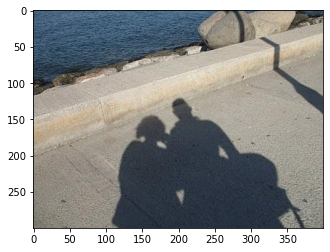

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


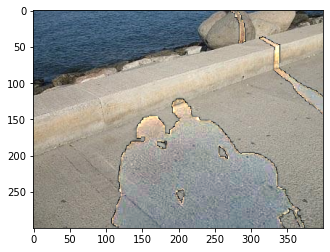

1.6696078431372547


In [365]:

new_img  = shadow_img.copy()*0


height = shadow_img.shape[0]
width = shadow_img.shape[1]

patch_size = 50
offset = 10

binIndx = np.arange(0,100,0.1)
bins = np.zeros((len(binIndx),3))



for x in np.arange(0,height,offset)[0:-1]:
    for y in np.arange(0,width,offset)[0:-1]:

        
        s, m, check = getPatch(mask_img, shadow_img, x, y, patch_size, width, height)
        
        if(check):
            
            #print(x,y)
            #print(np.sum(m))
            

            
            r = getIntensityRatio(s.copy(), m.copy())
            
            bins = updateBins(bins, binIndx, r)
            
            #fixedPatch = fixPatchShadow(s.copy(), m.copy(), r.copy())

            #shadow_img[x:xE, y:yE,:] = fixedPatch.astype('float64')
            #mask_img[x:(xE-0), y:(yE-0),:] = 0
            
            #plt.figure()
            #plt.imshow(m)
            #plt.show()
            

            

r = getFinalRatio(bins, binIndx)

print(r)


shadow_free_image = fixPatchShadow(shadow_img.copy(), mask_img.copy(), r)
#shadow_free_image = removeShadowImage(shadow_img.copy(), mask_img.copy(), r)


#final = rescale_images_linear(np.log(shadow_free_image))

            
plt.figure()
plt.imshow(shadow_img)
plt.show()

plt.figure()
plt.imshow(shadow_free_image)
plt.show()





print(np.max(shadow_free_image))


#shadow_img_blur = cv2.GaussianBlur(shadow_free_image,(5,5),0)

#plt.figure()
#plt.imshow(shadow_img_blur)
#plt.show()


#plt.savefig('after.png', dpi = 300)


#img = img_as_ubyte(shadow_img)
#cv2.imwrite("final.png", img)




##### r = getFinalRatio(bins, binIndx)

print(r)

In [167]:
a = np.arange(0,5,0.1)

print(a==0.8)


print(int(0.8*10))
print(np.where(a==0.8)[0][0])

bins = np.zeros((len(a),3))

print(bins)

bins[int(0.7*10),1]  = bins[int(0.7*10),1] +1

print(bins)


print(round(0.21, 1))



[False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
8
8
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 

In [ ]:
x = 375
y = 300

s = shadow_img[x:(x+12), y:(y+12),:].copy()

m = mask_img[x:(x+12), y:(y+12),:].copy()

r = computePatchRatio(s.copy(), m.copy())


fixedPatch = fixPatch(s.copy(), m.copy(), r.copy())

plt.imshow(s)
plt.show()

plt.imshow(fixedPatch)
plt.show()

r = computePatchRatio(fixedPatch.copy(), m.copy())

print(fixedPatch.shape)
print(shadow_img[x:(x+12), y:(y+12),:].shape)

shadow_img[x:(x+12), y:(y+12),:]  = fixedPatch.astype('float64')

#shadow_img[x, y,:] = fixedPatch[0,0,:].copy.astype('float64')



#img = (shadow_img*255).astype('uint8')


plt.figure()
plt.imshow(shadow_img)
plt.show()

#plt.savefig('after.png', dpi = 300)


img = img_as_ubyte(shadow_img)
cv2.imwrite("final.png", img)


# Shadow Removal


### Naive Approach

In [ ]:




def removeShadow(shadow_img, mask_img):

    shadow_pixels = shadow_img*mask_img


    x, y = np.nonzero(shadow_pixels[:,:,1])

    shadow_sample = shadow_pixels[x,y,:]


    non_shadow_pixels = shadow_img*np.logical_not(mask_img)
    x, y = np.nonzero(non_shadow_pixels[:,:,1])

    non_shadow_sample = non_shadow_pixels[x,y,:]


    if(non_shadow_sample.shape[0] > shadow_sample.shape[0]):
        sample_size = shadow_sample.shape[0]
    else:
        sample_size = non_shadow_sample.shape[0]

    ### Naive 1

    #r = (non_shadow_sample[0:sample_size,:] - shadow_sample[0:sample_size,:]) / (shadow_sample[0:sample_size,:]*1 - non_shadow_sample[0:sample_size,:]*0)
    #r = np.max(r, axis=0)

    #r = (shadow_img[300:310,200:210,:] - shadow_img[200:210,200:210,:]) / (shadow_img[200:210,200:210,:]*1 - shadow_img[300:310,200:210,:]*0)
    #r = np.mean(np.mean(r, axis=1), axis=0)
    
    
    r = (non_shadow_sample[100,:] - shadow_sample[100,:]) / (shadow_sample[100,:]*1 - non_shadow_sample[100,:]*0)

    print(non_shadow_sample[100,:])
    print(shadow_sample[100,:])
    
    print(r)

    shadow_mapper = (r + 1)/(r*np.logical_not(mask_img) + 1)
    
    print(shadow_mapper[200,200,:])
    print(shadow_img[200,200,:])

    mapped_image = np.multiply(shadow_img,shadow_mapper)
    print(mapped_image[200,200,:])

    max_vals = np.zeros(3, dtype= 'float64')
    max_valsBG = np.zeros(3, dtype= 'float64')


    fg = (mask_img*mapped_image)
    bg = shadow_img*np.logical_not(mask_img)


    max_vals[0]  = np.amax(fg[:,:,0])
    max_vals[1]  = np.amax(fg[:,:,1])
    max_vals[2]  = np.amax(fg[:,:,2])
    
    max_valsBG[0]  = np.amax(bg[:,:,0])
    max_valsBG[1]  = np.amax(bg[:,:,1])
    max_valsBG[2]  = np.amax(bg[:,:,2])

    print(max_valsBG[0])
    shadow_free_image = (fg/max_vals) + (shadow_img*np.logical_not(mask_img))


    #print(np.amax(shadow_free_image[:,:,1]))
    #print(max_vals[1])

    plt.figure()
    plt.imshow(shadow_free_image)
    plt.show()

    plt.figure()
    plt.imshow(shadow_img)
    plt.show()
    
    return shadow_free_image


In [ ]:

img1 = removeShadow(shadow_img, mask_img)


print(img1[200,200,:])

print(img1[200,300,:])

In [ ]:
img2 = removeShadow(img1, mask_img)

In [ ]:
removeShadow(img2, mask_img)

In [ ]:
def removeShadow(shadow_img, mask_img):

    shadow_pixels = shadow_img*mask_img

    fg = (mask_img*shadow_img.copy())
    bg = shadow_img.copy()*np.logical_not(mask_img)


    ## Range approach
    
    print('Non-Shadow Min Max')
    
    ns_max = np.max(bg)
    ns_min = np.min(bg)
    
    s_max = np.max(fg)
    s_min = np.min(fg)
    
    
    ns_diff = ns_max - ns_min
    s_diff = s_max - s_min
    
    print('ns_diff')
    print(ns_diff)
    print('s_diff')
    print(s_diff)
    print('ns_min')
    print(ns_min)
    
        
    fg = fg/s_diff
    
    fg = (fg*ns_diff) + ns_min 
    
    fg = (fg)*mask_img
    
    
    print(shadow_img[300,200])
    print(fg[300,200])
    print(mask_img[300,200])
    print(mask_img[200,200])
    
    print('npmaxmin')
    print(np.max(fg))
    print(np.min(fg))
    print(s_min)
    shadow_free_image = (fg) + (shadow_img*np.logical_not(mask_img))

    print(shadow_free_image[300,200])
    #print(np.amax(shadow_free_image[:,:,1]))
    #print(max_vals[1])

    plt.figure()
    plt.imshow(shadow_free_image)
    plt.show()

    plt.figure()
    plt.imshow(shadow_img)
    plt.show()
    
    return shadow_free_image


In [ ]:

shadow_img[:,:,0] = removeShadow(shadow_img[:,:,0].copy(), mask_img[:,:,0])
shadow_img[:,:,1] = removeShadow(shadow_img[:,:,0].copy(), mask_img[:,:,0])
shadow_img[:,:,2] = removeShadow(shadow_img[:,:,0].copy(), mask_img[:,:,0])

#print(img1[200,200])
#print(shadow_img[200,200])

#print(img1[300,400])
#print(shadow_img[300,400])

plt.figure()
plt.imshow(shadow_img)
plt.show()
    

In [ ]:
import cv2
import numpy as np

img = cv2.imread('SBU-shadow/SBU-Test/ShadowImages/exams.jpg', -1)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('shadows_out.png', result)
cv2.imwrite('shadows_out_norm.png', result_norm)